# Relaxation Methods for Solving Partial Differential Equations

## Poisson's equation

We aim to find solutions to the generic partial differential equation Poisson's equation, which is relevant to many physical systems. This has the form 

\begin{align}
\nabla^{2}V=-\rho
\end{align}

In this instance we will be considering the physical problem of solving Poisson's equation for a two dimensional closed region. This will allow calculation of the electic potential $V(x,y)$ and electric field $\textbf{E}(x,y)$ as a result of static charge, which is described by the charge density $\rho(x,y)$, or electric conductors, which are regions with fixed values of $V$. Fixing values of $V$ is equivalent to setting Dichrilet boundary conditions.

## Relaxation methods

Using approximations of the second partial derivate in $x$ and $y$, we can rewrite the Laplacian from its definition $\nabla^{2}V(x,y)=\frac{\partial ^{2}V}{\partial x^{2}}+\frac{\partial ^{2}V}{\partial y^{2}}$, this gives

\begin{align}
\nabla^{2}V(x,y)= \frac{V(x+h,y)+V(x-h,y)+V(x,y+h)+V(x,y-h)-4V(x,y)}{h^{2}}+O(h^{2}). 
\end{align}

This can be re-arranged to find the value of $V$ at specific coordinates in terms of the values of $V$ nearby, and the value of the Laplacian at those coordinates. Rearranging this way and substituting $\rho$ gives

\begin{align}
V(x,y)=\frac{1}{4}\left (V(x+h,y)+V(x-h,y)+V(x,y+h)+V(x,y-h)+h^{2} \rho(x,y)  \right )+O(h^4).
\end{align}

Applying this equation with a discretized grid of $x, y$ values we see that a grid point of electric potential $V(x,y)$, can be approximated by its 4 nearest neighbours, and $\rho(x,y)$, neglecting higher order terms. This scheme of calculating V is known as a relaxation method. Importantly, relaxation methods rely on the fact that when we make an initial guess for $V$ over the grid, then repeatedly compute the equation above for each grid point, our solution to $V$ will eventially convege to a solution. The grid must be truncated to a closed region of space, so it will not be possible to apply the relaxation algoritm at the edges where not all neighbour values are known. At these edges boundary conditions are set, where V does not change. Solutions are unique for given boundary conditions and $\rho$. 

### Setting up the problem 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

A function is defined that will return an array to be used as the initial solution for $V$. This will be initialised as 0 everywhere except boundaries. Assuming no knowledge of the form of the solution, setting grid points as 0 was generally found to converge faster than other guesses for the cases investigated here.

In [2]:
def gen_init_sol(n, bound_vals):
    init_sol = np.zeros((n, n))
    # Setting boundary conditions
    init_sol[-1, 1:-1], init_sol[:, -1], init_sol[0, 1:-1], init_sol[:, 0] = bound_vals
    
    return init_sol

A function is defined that will define a source selected from a few geometries of interest. This source may be passed as fixed charge in $\rho$ or a fixed voltage in $V$ when we start calculating the solution.

In [3]:
def gen_source(n, source_type):   
    
    source = np.zeros((n, n))
    
    if source_type == 'Zero' :
        pass
    elif source_type == 'Point Charge':
        source[int(n*.5), int(n*.5)] = 1
    elif source_type == 'Dipole':
        source[int(n*.4) ,int(n*.5)] = 1
        source[int(n*.6), int(n*.5)] = -1
    elif source_type == 'Capacitor': 
        source[int(n*.4), int(n*.2):int(n*.8)] = 1
        source[int(n*.6), int(n*.2):int(n*.8)] = -1
    elif source_type == 'Shell Capacitor':
        x, y = np.meshgrid(np.arange(-n//2, n//2),np.arange(-n//2, n//2))
        # Shells are defined by setting values within concentric circles of radii in list r 
        for i in range(3):
            r = [int(n*.4), int(n*.35), int(n*.25)][i]
            source[x**2 + y**2 < r**2]=[-1, 0, 1][i]
    else :
         raise Exception('Invalid Source')
                       
    return source

An example is shown for initial solution for $V$ and $\rho$. Here we set boundary conditions of $V=1$ at each boundary, and the source as a point charge which is approximated by setting $\rho=1$ at a single grid point and 0 elsewhere.

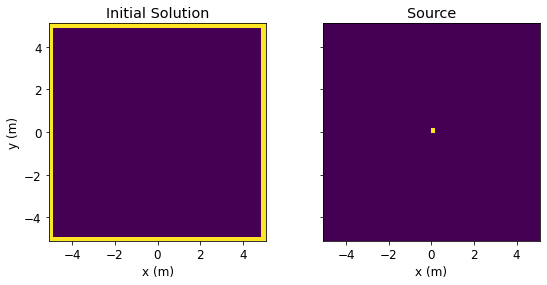

In [4]:
# Set grid size
n = 50
vals = np.linspace(-5, 5, n)
# Set x, y coordinates in metres
x, y = np.meshgrid(vals, vals)
# Initialise solution and source
init_sol = gen_init_sol(n, [1, 1, 1, 1])
rho = gen_source(n, 'Point Charge')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9, 4))
im = ax1.pcolormesh(x, y, init_sol, shading = 'auto')
im = ax2.pcolormesh(x, y, rho, shading = 'auto')
ax1.set_title('Initial Solution')
ax2.set_title('Source')
ax1.set_xlabel('x (m)')
ax2.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.show()

## Jacobi Method

The Jacobi method uses the equation for the approximation of $V$ shown earlier. We use i and j to index each value of V on the grid, and k to index the iteration number. A step using the Jacobi method on a single grid point can be expressed as

\begin{align}
V^{k+1}_{i,j} = \frac{1}{4} \left ( V^{k}_{i+1,j}+V^{k}_{i-1,j}+V^{k}_{i,j+1}+V^{k}_{i,j-1} +h^{2} \rho_{i,j}\right ).
\end{align}

The function below computes a single Jacobi iteration on the whole grid, using numpy arrays calculate each grid point in parallel.

In [5]:
def jacobi_step(V, rho, h):
    new_V = np.copy(V)
    # Get arrays shifted by one grid point each direction 
    right = V[1:-1, 2:]
    left = V[1:-1, :-2]
    top = V[:-2, 1:-1]
    bottom = V[2: ,1:-1]
    # Use arrays to calculate one jacobi step for all grid points in parallel
    new_V[1:-1, 1:-1] = (left + right + bottom + top + (h**2)*rho[1:-1, 1:-1])/4
    return new_V 

We now introduce an iterating function that can be called throughout the code to iterate from a desired initial V until the solution has sufficiently converged. The convergence condition used here is that for all grid points, the fractional change of $V$ from one iteration to the next must be below a given tolerance. That is, to accept the solution at iteration $V^{k+1}$ it must be true for for all pairs of $i,j$ that

\begin{align}
\left |\frac{V^{k+1}_{i,j}-V^{k}_{i,j}}{V^{k}_{i,j}}    \right |<\mathrm{tolerance}.
\end{align}

The function takes an input `stepfunc` so that we can use it with methods other than the Jacobi method, which are defined later.

In [6]:
def iterate(step_func, rho, h, init_sol, tol=1e-3, fixed_V = None): 
    V = np.copy(init_sol)
    iteration_number = 0
    not_converged = True
    while not_converged : 
        # Calculate one relaxation iteration with chosen step
        new_V = step_func(V,rho,h)
        
        # Reset V where it is supposed to be fixed (e.g for conductive region)
        if fixed_V is not None :
            new_V[fixed_V != 0] = fixed_V[fixed_V != 0]
            
        # Boolean variable set according to tolerance condition
        # In practice we multiply tol by V instead of dividing differences by V to deal with case V=0
        diffs = abs(new_V - V) 
        not_converged = np.any(diffs > tol*abs(V))
        
        V = new_V
        iteration_number += 1
        
    return V, iteration_number

The Jacobi method implementation in tested. The source is a point charge, the boundary conditions are all $V = 0$ and we use a grid size of 100 x 100.

Number of iterations = 6022


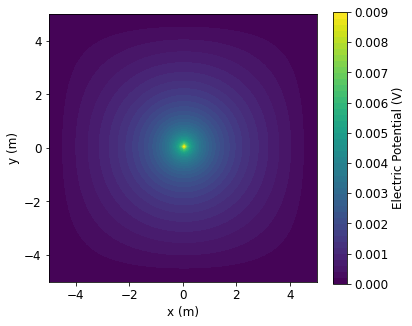

In [7]:
# Set parameters for problem
n = 100
vals = np.linspace(-5, 5, n)
x, y = np.meshgrid(vals, vals)
init_sol = gen_init_sol(n, [0, 0, 0, 0]) 
rho = gen_source(n, 'Point Charge')
h = x[0, 1] - x[0, 0]

# Iterate until solution converges
V, its = iterate(jacobi_step, rho, h, init_sol, tol=1e-4)
print('Number of iterations = %s' % (its))

# Plot result
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.contourf(x, y, V, 50)
ax.set_aspect('equal')
fig.colorbar(im, label='Electric Potential (V)')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
plt.show()

We can check this is truly a solution to the Poisson equation by calulating the Laplacian $\nabla^2 V$ and checking it is equal to our defined $\rho$

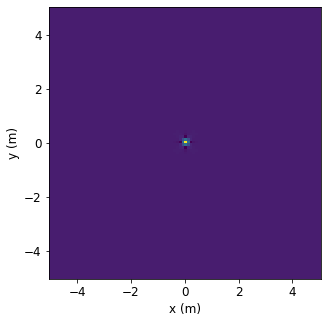

In [8]:
Ey,Ex = np.gradient(V)
rho = -(np.gradient(Ex)[1] +  np.gradient(Ey)[0])

# Plot result
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.pcolormesh(x, y, rho, shading='auto')
ax.set_aspect('equal')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
plt.show()

## Gauss-Seidel Method

The Gauss-Seidel method uses a similar iteration however it updates grid values in place. This means that as we sweep through the grid for a single iteration each value will be calculated by a combination of two grid points that have not yet been updated, and two that have already updated.

\begin{align}
V^{k+1}_{i,j} = \frac{1}{4} \left ( V^{k}_{i+1,j}+V^{k+1}_{i-1,j}+V^{k}_{i,j+1}+V^{k+1}_{i,j-1} +h^{2} \rho_{i,j}\right )
\end{align}

This is expected to reduce the number of iterations required, as the effect of a source on one side may propagate through the sweep to influence the potential on the other side. Although this depends on the direction we sweep through the grid. For the Jacobi method, each grid point is only updated based on its neighbours, so it will take many iterations for the influence of a source on the potential to propagate through the grid.

The function below computes a single Gauss-Seidel iteration on the whole grid.

In [9]:
def gauss_seidel_step(V, rho, h):
    n = np.shape(V)[0]
    new_V = np.copy(V)
    # Loop over every grid point
    for i in range(1, n-1):
        for j in range(1, n-1):
            # Update single grid point in place
            new_V[i, j] = (new_V[i-1, j] + new_V[i+1, j] + new_V[i, j-1] + new_V[i, j+1] + (h**2)*rho[i,j])/4
    return new_V

To demonstrate the difference between these methods we measure the iterations required for Jacobi and Gauss-Seidel methods to converge on different grid sizes. The specific problem is the solution for $V$ around a point charge, with boundary conditions $V=0$.

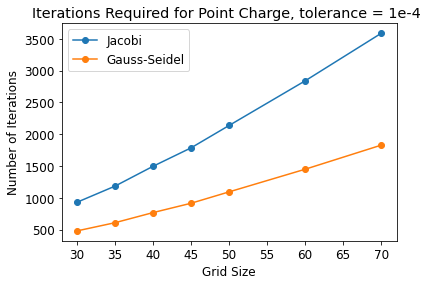

In [10]:
n_vals = [30, 35, 40, 45, 50, 60, 70]
J_iterations = np.zeros(len(n_vals))
GS_iterations = np.zeros(len(n_vals))

# Loop over different grid sizes
for i in range(len(n_vals)) :
    # Set parameters of problem
    n = n_vals[i]
    vals = np.linspace(-5, 5, n)
    x,y = np.meshgrid(vals, vals)
    init_sol = gen_init_sol(n, [0, 0, 0, 0]) 
    p = gen_source(n,'Point Charge')
    h = x[0, 1] - x[0, 0]
    
    # Save number of iterations required for each method to list
    J_iterations[i] = iterate(jacobi_step, p, h, init_sol, tol=1e-4)[1]
    GS_iterations[i] = iterate(gauss_seidel_step, p, h, init_sol, tol=1e-4)[1]

# Plot results
fig, ax = plt.subplots()
ax.plot(n_vals, J_iterations, 'o-', label='Jacobi')
ax.plot(n_vals, GS_iterations, 'o-', label = 'Gauss-Seidel')
ax.set_title('Iterations Required for Point Charge, tolerance = 1e-4 ')
ax.set_xlabel('Grid Size')
ax.set_ylabel('Number of Iterations')
ax.legend()
plt.show()

The Gauss-Seidel method clearly requires fewer iterations, and this improvement will grow as the grid sizes grows.

## Successive Over-Relaxation

To extend our methods, we now implement the Successive Over-Relaxation (SOR) iterative method. SOR updates grid values in place like Gauss-Seidel, however it attemps to step further towards the solution with each iteration. This is achieved by multiplying the difference between iterations by a factor $\omega$, so that $ V^{k+1}_{i,j} = V^{k}_{i,j} + \omega R^{k}_{i,j}$ where $R^{k}_{i,j}$ is the difference after a Gauss-Seidel step on a single grid point. We define a function below that will define an SOR step for any given value $\omega$.

In [11]:
def SOR_step_w(w) :
    # Define a method of SOR iteration depending on desired omega value
    def SOR_step(V, rho, h) :
        n = np.shape(V)[0]
        new_V = np.copy(V)
        # Loop over every grid point
        for i in range(1, n-1):
            for j in range(1, n-1):
                # Update single grid point in place
                new_V[i, j] = (V[i, j]*(1-w) 
                + (new_V[i-1, j] + new_V[i+1, j] + new_V[i, j-1] + new_V[i, j+1] + (h**2)*rho[i, j])*w/4)
        return new_V
    return SOR_step

Suitable values to chose are $1<\omega<2$. Setting $\omega<1$ is "under-relaxing" the grid, where each iteration changes grid value less than the Gauss-Seidel method, so this converges more slowly. Setting $\omega = 1$ is equivalent to the Gauss-Seidel method, and it is known that $\omega > 2$ does not converge. 

Finding optimal $\omega$ is not a trivial process as it varies between problems and grid size. To demonstrate this process we define a testing function to conduct a basic search for the best $\omega$ value for the point charge problem we have been considering thus far.

In [12]:
def test_omega(w_vals, n) :
    w_iterations = np.zeros(len(w_vals))
    
    # Set parameters of problem 
    vals = np.linspace(-5, 5, n)
    x,y = np.meshgrid(vals, vals)
    init_sol = gen_init_sol(n, [0, 0, 0, 0]) 
    rho = gen_source(n,'Point Charge')
    h = x[0, 1]-x[0, 0]
    
    # Loop through different values of omega
    for i in range(len(w_vals)): 
        w = w_vals[i]
        # Save number of iterations required to list
        w_iterations[i] = iterate(SOR_step_w(w), rho, h, init_sol, tol=1e-4)[1]
    return w_iterations

Next, we test number of iterations required to converge for different $\omega$. 

This is done for a smaller range of grid sizes for demonstration as this is a costly operation. Also, using the fact that optimal $\omega$ increases with grid size, we restrict the range of $\omega$ tested to values greater than the optimal for smaller grid sizes.

For n = 30, min iterations = 70 at omega=1.80
For n = 50, min iterations = 118 at omega=1.88
For n = 70, min iterations = 163 at omega=1.91


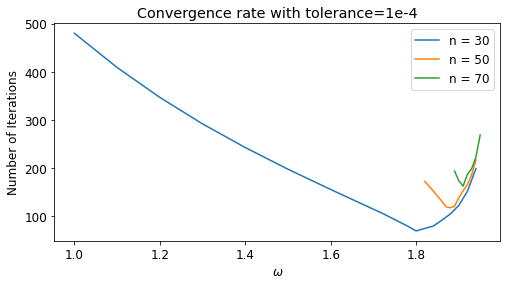

In [13]:
# Calculate and iterations required over different omega values for different grid sizes
n = 30
w_vals_30 = np.concatenate((np.arange(1.0, 1.7, 0.1), np.arange(1.7, 1.95, 0.02)))
w_iterations_30 = test_omega(w_vals_30, n)

n = 50
w_vals_50 = np.arange(1.82, 1.95, 0.01)
w_iterations_50 = test_omega(w_vals_50, n)

n=70
w_vals_70 = np.arange(1.89, 1.95, 0.01)
w_iterations_70 = test_omega(w_vals_70, n)

# Set up plot
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
plt.ylabel('Number of Iterations')
plt.xlabel('$\omega$')
ax.set_title('Convergence rate with tolerance=1e-4')

# Save all results to list for plotting
n_vals_SOR = [30, 50, 70]
w_all_vals = [w_vals_30, w_vals_50, w_vals_70]
w_all_its = [w_iterations_30, w_iterations_50, w_iterations_70]

for i in range(3) :
    n = n_vals_SOR[i]
    w_vals = w_all_vals[i]
    w_its = w_all_its[i]

    ax.plot(w_vals, w_its, label = 'n = %d' %(n) )
    
    # Measure and print minimum iterations
    min_iterations = min(w_its)
    min_w =  w_vals[w_its == min_iterations]
    print("For n = %s, min iterations = %d at omega=%.2f" % (n_vals_SOR[i], min_iterations, min_w))
    
ax.legend()
plt.show()

To put this in context we compare with the results for Gauss-Seidel.

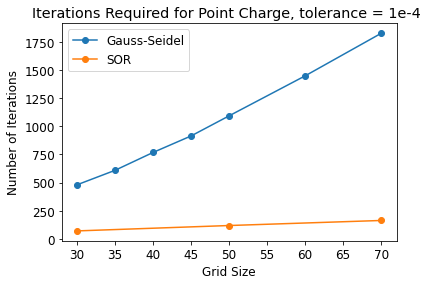

In [14]:
fig, ax = plt.subplots()
ax.plot(n_vals, GS_iterations, 'o-', label = 'Gauss-Seidel')
ax.plot([30, 50, 70], [70, 118, 163], 'o-', label = 'SOR')
ax.set_title('Iterations Required for Point Charge, tolerance = 1e-4 ')
ax.set_xlabel('Grid Size')
ax.set_ylabel('Number of Iterations')
ax.legend()
plt.show()

SOR is known to converge much faster than the Gauss-Seidel method, however, we must take into account the extra cost of needing to find optimal $\omega$, which can be a slow process. It has been shown that $\omega$ can be expressed as a function of $n$ for a given problem. This allows the more convenient strategy of measuring the optimal value of $\omega$ for several small grids, then predicting optimal values at much larger grid sizes. In this case SOR will be particularly valuable, as the speedup offered by SOR will become much more important at higher $n$.

Although the Gauss-Seidel and SOR methods converge with far fewer iterations than with the Jacobi method, with the implementations used here the Jacobi method is faster to compute. This is because it is easy to implement the Jacobi method with an algorithm that takes advantage of parallel operations using numpy arrays. For the other two methods, each value to be updated sequentially as the function sweeps through the grid. This issue can be overcome with more complex implementation, but in this code the Jacobi method will be used for further results. However, it is worth noting that even with the parellization, the Jacobi method would fall behind the other methods given large enough grid size.

## Results for Different Problems

We will now find the solution to Poisson's equation for a point charge, a dipole of two charges, and conductive plates making a standard capacitor and a shell capacitor. 

The former two problems involve setting fixed values of $\rho$. The latter two requre setting $\rho = 0$, essentially solving Laplace's equation, but with fixed values of $V$ within the grid representing the conductors, rather than just having fixed $V$ at the boundaries. All four problems set boundary conditions as $V=0$, the physical significance of which is discussed with the results.

In [15]:
# Set parameters for problem
n = 100
vals = np.linspace(-5, 5, n)
x, y = np.meshgrid(vals, vals)
h = x[0, 1] - x[0, 0]
init_sol = gen_init_sol(n, [0,0,0,0]) 

# Create lists of arrays for the two charge geometries and two conductor geometries of interest
rho_vals = ['Point Charge', 'Dipole', 'Zero', 'Zero']
fixed_V_vals = ['Zero', 'Zero', 'Capacitor', 'Shell Capacitor']
rho_list =  [gen_source(n, source) for source in rho_vals]
fixed_V_list = [gen_source(n, source) for source in fixed_V_vals]

# Iterate to solution for each of these four problems
V_list = []
for i in range(4):  
    h = x[0,1]-x[0,0]
    V, its = iterate(jacobi_step, rho_list[i], h, init_sol, tol=1e-5, fixed_V = fixed_V_list[i] )
    V_list.append(V)

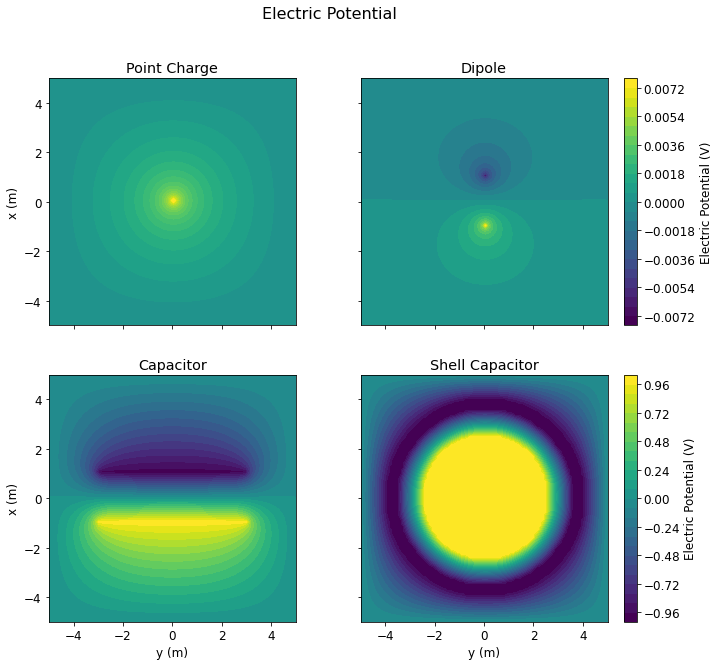

In [16]:
# Set up plot
fig, axs = plt.subplots(2,2,sharey=True, sharex=True, figsize=(12, 10))
axs = axs.ravel()
fig.subplots_adjust(wspace=0, hspace=.2)
fig.suptitle('Electric Potential', fontsize=16)
plt.setp(axs[2:], xlabel='y (m)')
plt.setp(axs[0::2], ylabel='x (m)')
vmins = [np.min(V_list[1]), -1]
vmaxs = [np.max(V_list[1]), 1]
titles = rho_vals[:2] + fixed_V_vals[2:]

# Plot V
for i in range(4) :
    ax = axs[i]
    im = ax.contourf(x, y, V_list[i],25, vmin = vmins[i//2], vmax = vmaxs[i//2])
    ax.set_title(titles[i])
    ax.set_aspect('equal')
    if i % 2 == 1 :
        fig.colorbar(im, ax=ax, label = 'Electric Potential (V)')
        
plt.show()

### Significance of Boundary Conditions

Setting V = 0 at the boundaries means it must approach zero as we move between the charge and the boundaries. As the Laplacian of the field must be zero in this region where there is no charge, the result is a smooth function that varies between the expected reciprocal dependance on radius, observed in circular contours near the charge, and a flattening of the potential towards the boundaries in more squared out contours. The true electric potentials calculated here are that of the specified charges or voltages on a grounded plate of dielectric. Numerically calculating the electric potential of charges in unbounded space, as is often done in theoretical work, is much more difficult. 

To simulate an open region, for a point charge, the boundary conditions could just be set as the calculated values of V for a charge in an open system. However for more complex arrangements we will not have prior knowledge of electric potential at the boundaries. Typically, the way to overcome this problem is to run the iterations over a much larger region, where the region of interest is very far away from the boundaries, so that their influence is minimised. This will require a larger grid size, and more detailed analysis of the complexity of these algorithms reveals that enlarging the grid quickly becomes very computationally expensive, this is where SOR becomes particularly valuable. 

Another way to enconomise on computation for large regions is multigrid methods. This involves solving the problem with a coarser grid, then interpolating this solution over a finer grid to initialise the solution for the same problem on a finer grid. The roughly correct initial solution will reduce iterations required, and this can be used recursively to keep increasing grid size. 

### Electric Field

A vector plot is now used to show, the electric field. This can be calculated using $\mathbf{E}=-\boldsymbol{\nabla} V $ and is computed using numpy's gradient function on the iterative $V$ solution.

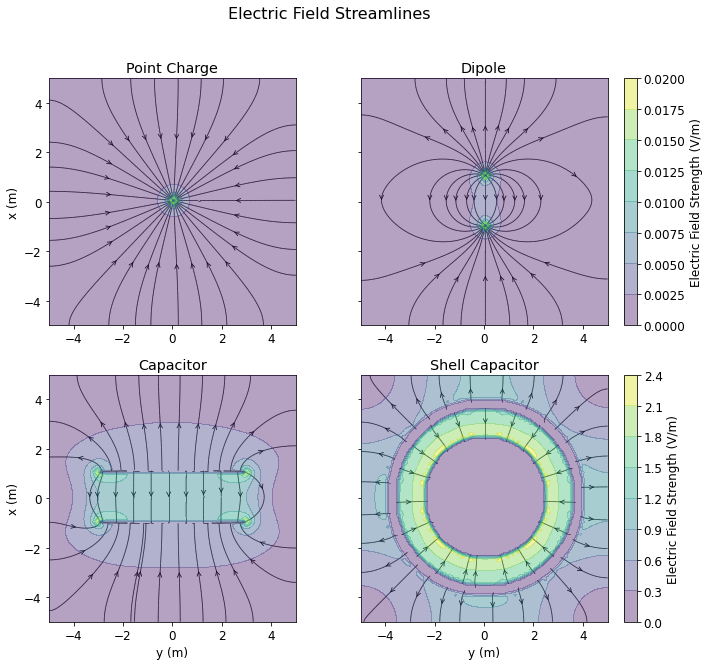

In [17]:
# Calculate E
E_list = [np.gradient(V) for V in V_list]/h

# Set up plot
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(12, 10))
fig.suptitle('Electric Field Streamlines', fontsize=16)
axs = axs.ravel()
plt.setp(axs[2:], xlabel='y (m)')
plt.setp(axs[0::2], ylabel='x (m)')        
fig.subplots_adjust(wspace=0, hspace=.2)

# Particular electric potential contours are chosen to seed streamlines for streamplot
levels = [np.array([2]), np.array([3]),np.array([2]),np.array([.7])]
indices = [[0],[0,1],[0,1],[0,1]]
# Number of seeds for streamlines
n_seed = [26, 40, 42, 44]

for i in range(4) :
    Ey, Ex = E_list[i] 
    V = V_list[i]
    ax = axs[i]

    # Calculate points to seed streamlines
    cs = ax.contour(x, y, np.abs(V), levels = levels[i]*np.mean(np.abs(V)), alpha=0).allsegs[0]
    cs_arr = np.concatenate([cs[j] for j in indices[i]])
    nd = np.shape(cs_arr)[0]
    seed_points = cs_arr[::(nd//n_seed[i]),:]
    # Plot streamlines
    im = ax.streamplot(
        x, y, Ex, Ey, 
        start_points=seed_points, color='k', arrowstyle='->', density=10, linewidth=.8, zorder=1
    )
    
    # Plot E field strength
    E_strength = np.sqrt(Ex**2 + Ey**2)
    im = ax.contourf(x, y, E_strength, alpha = 0.4, zorder= 5)
    
    axs[i].set_title(titles[i])
    ax.set_aspect('equal')
    if i % 2 == 1 :
        fig.colorbar(im, ax=ax, label='Electric Field Strength (V/m)')
plt.show()

The Electric field stream lines show the expected results, again with some difference as to what would be expected in an open region, particularly near the boundaries. The region inside the capacitors should experience less influence from any outside potential and are therefore roughly insensitive to boundary conditions, this is due to the shielding effect of the fixed electric potential on the plates, which acts like a partial or complete Faraday cage. The constant magnitude of Electric field within the capacitor suggests the model is successful. As expected this field changes slightly at the edges of the capacitor. The same cannot be said for the shell capacitor, where the innner field should be completely even. 

A slice of the electric potential along the $y=0$ line is shown below. The electric potential varies linearly between the two plates for the shell capacitor, additionally contours for electric potential of the shell capacitor showed evenly spaced circles, this should result a constant electric field. It's possible that the varying field seen above is a result of calulating the gradient numerically with a limited number of grid points and on a cartesian grid for a problem which has polar symmetry.

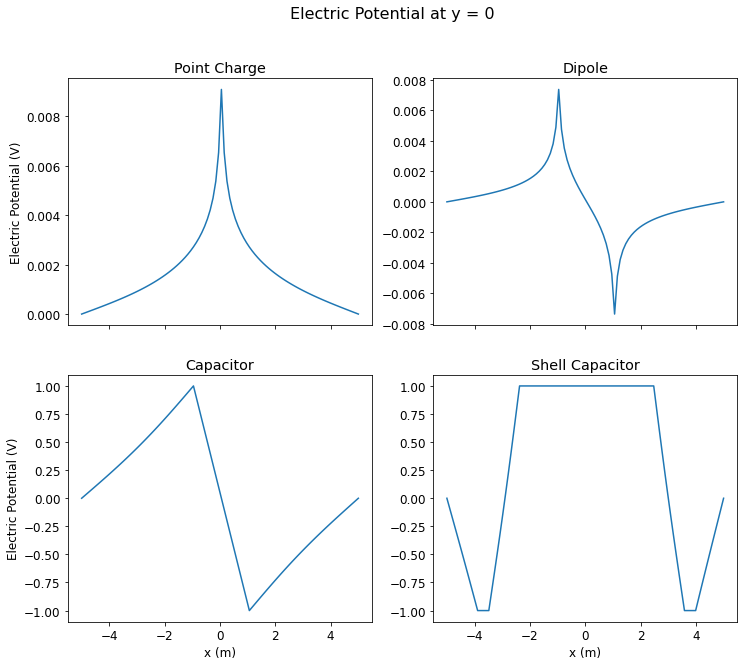

In [18]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 10))
fig.suptitle('Electric Potential at y = 0', fontsize=16)
axs = axs.ravel()

for i in range(4) :
    im = axs[i].plot(vals, V_list[i][:,n//2])
    axs[i].set_title(titles[i])
    
plt.setp(axs[2:], xlabel='x (m)')
plt.setp(axs[0::2], ylabel='Electric Potential (V)')
plt.show()

Due to the nature of the discrete grid, we do not see the electric potential diverging towards infinity at the point charge. As discussed earlier, the reciprocal law expected for V with r is not followed as we approach the boundaries due to boundary conditions. The capacitors show linear variation of potential between the conductive plates as expected. 

## Solving Laplace's Equation

We now use the methods tested above to find solutions to Laplace's equation, $\nabla^{2}V=0$. Solutions found are unique to boundary conditions.

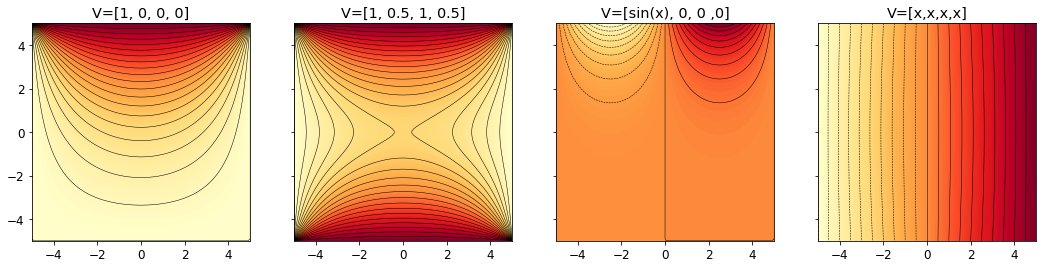

In [19]:
# Set parameters for problem
n = 100
vals = np.linspace(-5, 5, n)
x,y = np.meshgrid(vals, vals)
h = x[0, 1] - x[0, 0]
rho = gen_source(n,'Zero')
bounds = [
    [1, 0, 0, 0],
    [1, .5, 1, .5],
    [1, 0, 0, 0],
    [1, 1, 1, 1]]

# Set initial solutions and boundary conditions
init_sols = [gen_init_sol(n, bound) for bound in bounds]
init_sols[2] *= np.sin(x*np.pi/5)
init_sols[3] *= x

# Iterate to solution for each set of boundary conditions
laplace_sols=[]
for init_sol in init_sols: 
    V, its = iterate(jacobi_step, rho, h, init_sol, tol=1e-4)
    laplace_sols.append(V)

# Plot    
f, axs = plt.subplots(1, 4, sharey=True, figsize=(18,4))
axs = axs.flatten()
titles =  ['V=[1, 0, 0, 0]','V=[1, 0.5, 1, 0.5]','V=[sin(x), 0, 0 ,0]', 'V=[x,x,x,x]']
for i in range(4):
    ax = axs[i]
    im = ax.contourf(x, y, laplace_sols[i], 100, cmap='YlOrRd')
    imc = ax.contour(im,levels=im.levels[::5],colors='black',linewidths=0.5)
    ax.set_title(titles[i])
plt.show()

Solutions to Laplace's equations are shown with different boundary conditions. The boundary conditions are shown in the titles in the order $\left [V(0,5),V(5,0),V(0,-5),V(-5,0)  \right ]$. These are Dichrilet boundary conditions as the potential $V$ is set, but it is also possible to solve the problem setting Neumann boundary conditions, which set values for $\nabla V $ or $E$ in the context of electrostatics.

This equation also applies to heat flux, for example the first solution shown here would corresponding to the steady state distribution of heat, after heat has been allowed to diffuse from the constant source of heat at the top of the grid, towards the heat sinks on the other three edges. In this context, steps with Jacobi method actually correspond to time steps, and by saving each individual iteration a time series of heat diffusion can be calculated. 

# Appendix

A function was also defined that attempts to implement a parallel algorithm for SOR using the red-black method, this was not fully tested.

In [20]:
def SORPar(V,rho,h):
    w=1.995
    
    new_V = np.copy(V)
    n = np.shape(V)[0]
    z = np.zeros((n,n))
    avg1 = jacobi_step(V,rho,h)
    avg2 = jacobi_step(avg1,rho,h)

    new_V[1:-1:2,1:-1:2] *= (1-w)
    new_V[1:-1:2,1:-1:2] += w*avg1[1:-1:2,1:-1:2]
    new_V[2:-1:2,2:-1:2] *= (1-w)
    new_V[2:-1:2,2:-1:2] += w*avg1[2:-1:2,2:-1:2]
    new_V[1:-1:2,2:-1:2] *= (1-w)
    new_V[1:-1:2,2:-1:2] += w*avg2[1:-1:2,2:-1:2]
    new_V[2:-1:2,1:-1:2] *= (1-w)
    new_V[2:-1:2,1:-1:2] += w*avg2[2:-1:2,1:-1:2]
    return new_V


In [21]:
from scipy.interpolate import interp2d 

Interpolating a solution from an n=100 size solution from earlier to initialise the n=200 problem

In [22]:
vals0 = np.linspace(-10,10,100)
h = vals0[1]-vals0[0]
rho = gen_source(100,'Point Charge')
init_sol = gen_init_sol(100, [0,0,0,0])
V0, its = iterate(jacobi_step, rho, h, init_sol, 1e-5 )

f = interp2d(vals0, vals0, V0)

vals = np.linspace(-10,10,200)
x, y = np.meshgrid(vals,vals)

init_sol = f(vals,vals)

In [23]:
h = x[0,1]-x[0,0]
rho = gen_source(200,'Point Charge')
V, its = iterate(SORPar, rho, h, init_sol, 1e-5 )
print(its)

11277


Here we show only the region of interest near the charge, as the boundaries are further away this is a closer approximate to a charge in an open region.

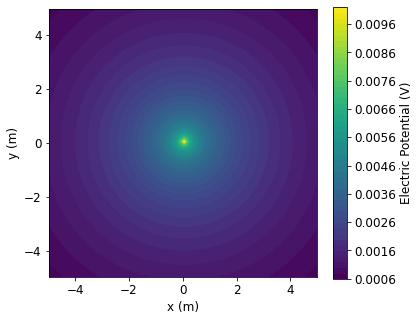

In [24]:
fig, ax = plt.subplots(figsize=(6,5))

index = np.logical_and(abs(x) < 5, abs(y) < 5)
im = ax.contourf(x[index].reshape(100,100), y[index].reshape(100,100), V[index].reshape(100,100), 50)
ax.set_aspect('equal')
plt.colorbar(im, label = 'Electric Potential (V)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()